# Self gathered image set from video of robot soccer game
## -- Dataset v1: original video screenshots
- I used ffmpeg to automatically capture images every 1 second from the .mp4 files of the videos. And manually label the images with “soccer” or “no_soccer” in the images. Then I put each of the categories in a list, shuffle the indices, in order to randomly put images to validation set. The number of images is 500-600 (variation due to later adjustment of the dataset, see below), and the ratio of images between training set and validation set is roughly 2:1.

## -- Result of using Dataset v1 for training and validation
- Result of using original uncropped screenshots: Training complete in 24m 55s, Best val Acc: 0.960328. I think the validation loss is very high because of 2 reasons: 1. many images are consecutive in the videos, so they look very alike, so many images in the validation set may have similar counterparts in the training set. So the network model can just memorize those images, and produce high accuracy in validation. 2. both the training dataset is unbalanced between soccer and no-soccer images: number of images with soccer are more than 3 times the number of images without soccer (around 1500:440), so if the prediction is always “with soccer”, the accuracy will most likely be quite high.
- In order to solve these problems, I select only 1 image from every 10 consecutive with-soccer images, and randomly crop 3 sub-images out of this image, and use these images as training data. For the no-soccer images, I select one from every 3 consecutive no-soccer images and randomly crop 2 images out of this image, and use these as training data. After that I re-label the data and found out no-soccer images are more than with-soccer images, so I selected the with-soccer images that haven’t been used, and choose 1 image from 10 consecutive images, and then randomly crop one image out of it. 

## -- Dataset v2: images of certain size (360*\540)
- But I later found out the problem is that in order to do batched training, all images in the same batch should have the same shape after transformation, so if the initial images have different aspect ratios then the resulting images after transformation have different shapes, resulting in error. If I directly resize the image to a certain size such as (224,224), then the images that are not square will be squeezed in an unnatural way, so I cropped the original images randomly again with certain aspect ratio (2:3), and resized them all to (360,540) as the new dataset. However, when I try to run with this dataset there is always an “size mismatch” error in the forward propagation step. 

## -- Dataset v3: certain aspect ratio (squared)
- After searching online, I found that pre-trained resnet NN only accepts input of size (224,224) (I suppose this is because ImageNet images are of this size), so I have 2 options now: either using Dataset v2 and when transforming with data loader I crop a squared image out of each image and resize to (224,224); or I can crop the original video images again into squared images, relabel and resize to (224,224) during data loading (Dataset v3). I tried both and the result best test accuracy of the second option (acc=0.964912) is better than the first one (acc=0.897436), with the same hyperparameters (normalization: (mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225]), pretrained resnet18, optimizer: SGD, lr=0.001, momentum=0.9, batch_size=4, scheduler: StepLR(optimizer_ft, step_size=7, gamma=0.1)). The first is lower may be because when randomly cropping during data loading, some images labeled as “soccer” might actually become an image without soccer in them, then this lead to miss classification.

## -- Fine tuning using Dataset v2 (resizing to square image during data loading)
- See the 1st cell below

## -- Dataset v4: Another way to separate training and validation sets
- Then I think if I randomize all the images and separate into training set and validation set like I did before, this will result in some similar images (those close to each other in the image sequence) between training set and validation set, although this situation is improved with the random cropping of the original video images applied in Dataset v3. So I created another dataset from the dataset by not randomly choosing and putting images to validation set, but rather put the first 2/3 of the sequential images to training set, and the rest to validation set, which I think is more strict, because for each image in validation set, there are almost no highly similar images in the training set. The resulting best accuracy of this dataset (with the same hyperparameters mentioned above) is indeed a bit lower (acc=0.919598) than using v3 (acc=0.964912).

## -- Fine tuning using Dataset v4
- See the 2nd cell below

## Result: Fine tuning using Dataset v4
### Best model
- Best val Acc: 0.944724
- optimizer: SGD, lr=0.001, momentum=0.9
- optim.lr_scheduler.ReduceLROnPlateau

### On finetuning the parameters

For different models, I tried finetuning resnet18 , resnet34 and resnet50 on the same dataset and other parameters unchanged except the following: 

#### Using lr_scheduler.StepLR:

For resnet18,  
- optimizer: SGD, lr=0.001, momentum=0.9 - Best val Acc: 0.914573
- optimizer: SGD, lr=0.05, momentum=0.9 - Best val Acc: 0.522613 (almost cannot learn)
- optimizer: SGD, lr=0.0005, momentum=0.9 - Best val Acc: 0.899497
- optimizer: Adadelta, lr=0.01 - Best val Acc: 0.904523

For resnet34,
- optimizer: SGD, lr=0.001, momentum=0.9 - Best val Acc: 0.919598 
 - only slight improvement compared to resnet18: this might be because the learning task is just 2 class classification of images that share a similar background (mostly in the soccer field), so it does not need the neural network to be very complicated to learn the necessary features important for discriminating "soccer" and "no_soccer", so resnet18 already has satisfying performance
- optimizer: Adadelta, lr=0.01 - Best val Acc: 0.919598

For resnet50,
- optimizer: SGD, lr=0.001, momentum=0.9 - Best val Acc: 0.929648 (slightly improved compared to resnet34)

#### Using other schedulers:

For schedulers, I tried the following lr_scheduler with optimizer SGD, lr= 0.001, momentum=0.9 (and resnet50):

- optim.lr_scheduler.StepLR - Best val Acc: 0.929648
- optim.lr_scheduler.ReduceLROnPlateau - Best val Acc: 0.944724
lr_scheduler.ReduceLROnPlateau has better performance

I also tried optim.lr_scheduler.ReduceLROnPlateau with optimizer Adadelta, lr= 0.01 (and resnet50)
 - Best val Acc: 0.934673

### Using ConvNet as fixed feature extractor
- With the best hyperparameters above: Best val Acc: 0.814070
 - significantly lower than fine tuning the whole model, although much faster (use only half the time)
 - I guess this might be because imagenet is used to train resnet, and it contains few similar images to soccer games, but the insect images comes also from imagenet. So the hidden feature extracted by resnet is more readily applied to the insect images than the soccer images?

In [1]:
# Adapted from the codes by Sasank Chilamkurthy
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

# Load Data
Made screenshots of the RoboCup videos, and manually labeled (has ball vs. no ball in the image). 
Then generated a file folder structure that can be read by the ImageFolder

In [2]:
# !unzip Dataset_v4.zip #extract it to the current directory.
# !unzip Dataset_v2.zip
# !unzip Dataset_v3.zip

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
# for the normalization numbers [0.485,456,...] recommended by http://pytorch.org/docs/master/torchvision/models.html?highlight=torchvision%20models

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Dataset_v4' 
# data_dir = 'Dataset_v2'
# data_dir = 'Dataset_v3'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=10)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

# Visualize a few training images

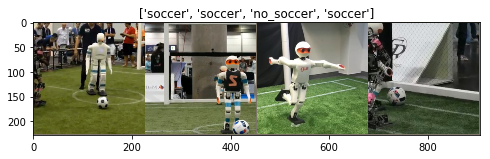

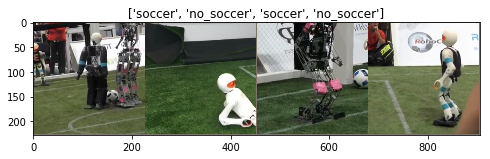

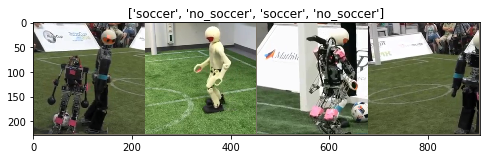

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # reconstruct the orginal image from the normalized one
    inp = np.clip(inp, 0, 1) #Clip (limit) the values in array to [0,1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

i=0
for inputs, classes in iter(dataloaders['train']):
    # Get a batch of training data
    fig = plt.figure(figsize=(8, 6))
    
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])
    i+=1
    if i>=3:
        break

Training the model
------------------
-  Scheduling the learning rate (reducing learning rate in every x training epochs)
-  Saving the best model

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
# def train_model(model, criterion, optimizer, num_epochs=25):

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler.step(epoch_loss) # For schedulers other than lr_scheduler.ReduceLROnPlateau
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                # print("pass")

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if phase == 'train': # for lr_scheduler.ReduceLROnPlateau only
                scheduler.step(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions


Generic function to display predictions for a few images




In [32]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [33]:
# model_ft = models.resnet18(pretrained=True) # check: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
model_ft = models.resnet50(pretrained=True)   #keeps running into memory error!!!!!!
# model_ft = models.resnet34(pretrained=True)

num_ftrs = model_ft.fc.in_features # only one fully connected layer in each resnet model
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adadelta(model_ft.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min')
# exp_lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.1)

# Train and evaluate

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1309 Acc: 0.7405
val Loss: 0.1225 Acc: 0.7337

Epoch 1/24
----------
train Loss: 0.0723 Acc: 0.9084
val Loss: 0.0916 Acc: 0.8342

Epoch 2/24
----------
train Loss: 0.0685 Acc: 0.8957
val Loss: 0.0850 Acc: 0.8593

Epoch 3/24
----------
train Loss: 0.0527 Acc: 0.9135
val Loss: 0.0711 Acc: 0.8894

Epoch 4/24
----------
train Loss: 0.0330 Acc: 0.9593
val Loss: 0.0678 Acc: 0.8894

Epoch 5/24
----------
train Loss: 0.0317 Acc: 0.9593
val Loss: 0.0725 Acc: 0.8744

Epoch 6/24
----------
train Loss: 0.0290 Acc: 0.9746
val Loss: 0.0637 Acc: 0.8945

Epoch 7/24
----------
train Loss: 0.0307 Acc: 0.9542
val Loss: 0.0644 Acc: 0.8945

Epoch 8/24
----------
train Loss: 0.0479 Acc: 0.9109
val Loss: 0.0582 Acc: 0.9146

Epoch 9/24
----------
train Loss: 0.0261 Acc: 0.9669
val Loss: 0.0558 Acc: 0.9196

Epoch 10/24
----------
train Loss: 0.0381 Acc: 0.9313
val Loss: 0.0646 Acc: 0.9146

Epoch 11/24
----------
train Loss: 0.0272 Acc: 0.9567
val Loss: 0.0574 Acc: 0.9347

Ep

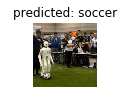

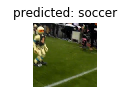

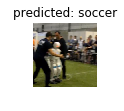

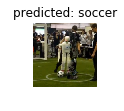

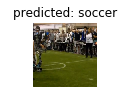

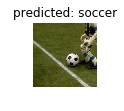

In [34]:
visualize_model(model_ft)

In [35]:
# del model_ft #delete the model in order to avoid becoming out of memory 

In [24]:
# Save the best model
# torch.save(model_ft.state_dict(), "model_resnet50_scheduler_ReduceLROnPlateau")

ConvNet as fixed feature extractor
----------------------------------

Freeze all the network except the final layer

In [47]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False # do not change the weights in the resnet layers

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min')


# Train and evaluate

In [48]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6890 Acc: 0.6641
val Loss: 0.5316 Acc: 0.6683

Epoch 1/24
----------
train Loss: 0.5898 Acc: 0.7659
val Loss: 0.9119 Acc: 0.5930

Epoch 2/24
----------
train Loss: 1.1611 Acc: 0.6947
val Loss: 1.8628 Acc: 0.5427

Epoch 3/24
----------
train Loss: 0.9463 Acc: 0.7405
val Loss: 0.5190 Acc: 0.7839

Epoch 4/24
----------
train Loss: 0.9252 Acc: 0.7659
val Loss: 0.5792 Acc: 0.7739

Epoch 5/24
----------
train Loss: 0.5378 Acc: 0.8321
val Loss: 0.6021 Acc: 0.7588

Epoch 6/24
----------
train Loss: 0.4583 Acc: 0.8346
val Loss: 0.7452 Acc: 0.7035

Epoch 7/24
----------
train Loss: 0.5444 Acc: 0.8193
val Loss: 0.5049 Acc: 0.7688

Epoch 8/24
----------
train Loss: 0.8467 Acc: 0.7939
val Loss: 0.5805 Acc: 0.7487

Epoch 9/24
----------
train Loss: 0.3785 Acc: 0.8524
val Loss: 0.6453 Acc: 0.7437

Epoch 10/24
----------
train Loss: 0.6713 Acc: 0.7837
val Loss: 1.8965 Acc: 0.6030

Epoch 11/24
----------
train Loss: 0.8316 Acc: 0.7684
val Loss: 1.9135 Acc: 0.5980

Ep

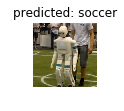

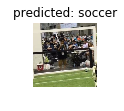

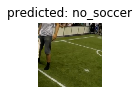

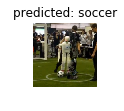

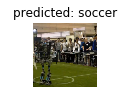

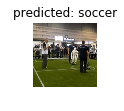

In [38]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [49]:
# del model_conv #delete the model in order to avoid becoming out of memory 